## Compute the emittance growth for white noise case including the contribution of the tune distribution 

In [1]:
import scipy.integrate as integrate
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.constants import m_p, c
import pandas as pd

In [2]:
def emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaPhi, noise_psd, rho_b): 
    
    ey_rate = betay*(Vcc*frev/(2*Eb))**2*CDeltaPhi
    
    
    #result = integrate.quad(lambda vb: noise_psd(vb*frev)*rho_b(vb), 0.1, 2)
    x = np.linspace(0.,1, 100000)
    dx = x[1]-x[0]
    y = np.array(noise_psd(x*frev)*rho_b(x))
    result = integrate.trapz(y,dx=dx)
    
    #print(result)
    
    #print(2*ey_rate)
    return 2*result*ey_rate

In [3]:
def expon_distribution(x, mu, b): 
    return np.heaviside(x-mu, 1)*(1/b) * np.exp(-(x-mu)/b)
  

In [4]:
def gaussian_distribution(x, mu, c, alpha):
    return alpha*np.exp(-(x-mu)**2/(2*c**2))

In [5]:
def cmpt_rms_JxJy(epsn_x, epsn_y, beta_0, gamma_0, betay, betax):
    # Compute the geometric emittances in m
    ex_geom = epsn_x/(beta_0*gamma_0)  
    ey_geom = epsn_y/(beta_0*gamma_0)  
    
    # Compute the beam sigmas 
    sigma_x = np.sqrt(ex_geom*betax)
    sigma_y = np.sqrt(ey_geom*betay)
    print('σ_x = {} m, σ_y = {} m'.format(sigma_x, sigma_y))

    my_sigmas_x = 1*sigma_x
    my_sigmas_y = 1*sigma_y
    
    Jx = my_sigmas_x**2/(betax)
    Jy = my_sigmas_y**2/(betay)
    print('At {}σ Jx = {} m and Jy = {} m'.format(my_sigmas_x/sigma_x, Jx, Jy))
    
    return Jx, Jy

In [6]:
def dQy_cmpt(Jx, Jy, app_y, app_xy):
    return (app_y*2*Jy+app_xy*2*Jx)

### SPS parameters

In [7]:
betay = 73. # m
betax = 29. # m 
# Beam parameters
Vcc = 1e6# V
frev = 43.45e3 # Hz
Eb = 270e9 # eV
CDeltaPhi = 0.52 # approx
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
# normalised transvesre emittance
epsn_x    = 2e-6 # m
epsn_y    = 2e-6 # m
# relativistic parameters
gamma_0 = 287.7
p0 = m_p*c*np.sqrt(gamma_0**2 - 1)
beta_0 = np.sqrt(1 - 1/gamma_0**2)

### Function for tune distribution

In [12]:
rho_b = lambda vb : expon_distribution(vb, 0.18, 0.0014)

In [13]:
# Sanity check, it should equal 1
integrate.quad(lambda vb: rho_b(vb), 0.1, 2) 

(1.000000000369618, 1.6411272954959723e-09)

### A) Create a list of tune distributions distributions, for given standard deviation

To use the function dQy_cmpt we need to compute the Jy and Jx

In [14]:
Jx, Jy = cmpt_rms_JxJy(epsn_x, epsn_y, beta_0, gamma_0, betay, betax)

σ_x = 0.00044899900395007383 m, σ_y = 0.0007123735872133087 m
At 1.0σ Jx = 6.9517277775227045e-09 m and Jy = 6.951727777522706e-09 m


In [15]:
app_x = 0.0 
app_xy = 0.0 
app_y_list = np.linspace(-3e5, 3e5, 10)

In [16]:
# create the list with the rms DQy of interest = std of the tune distribution
rms_DQy_list = []
for app_y in app_y_list:
    Dqy = dQy_cmpt(Jx, Jy, app_y, app_xy)
    rms_DQy_list.append(Dqy)
print(rms_DQy_list)

[-0.004171036666513623, -0.003244139629510596, -0.002317242592507569, -0.0013903455555045413, -0.00046344851850151347, 0.0004634485185015143, 0.0013903455555045413, 0.002317242592507569, 0.003244139629510597, 0.004171036666513623]


### Create list of the PSDs
Import tha file, created from: /home/natalia/PhD_projects/utils/noise_studies_playground/PSD_computation/job002_compute_PSD_colored_iterate_over_rmsKsi.ipynb


In [33]:
df1 = pd.read_pickle('rmsksi_vs_PSD.pkl')
psd_vb_list = list(df1['PSD_vb_list'])

In [38]:
psd_vb_liist = [psd_vb_list[0]]

In [58]:
dey_dict = {} 
emity_list = []
for psd in psd_vb_liist:
    
    
    alpha = psd*(scale_factor)**2 
    mu = 0.18*frev
    c = 0.06*frev # the rms width of the colored noise
    noise_psd = lambda f : gaussian_distribution(f, mu, c, alpha)
    
    
    for rms_DQy in rms_DQy_list[:int(len(rms_DQy_list)/2)]: 
        rho_b = lambda vb : expon_distribution(vb, 0.18, np.abs(rms_DQy))
        
        emit_y_geom = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaPhi, noise_psd, rho_b)
        
        emity_list.append(emit_y_geom*beta_0*gamma_0)

In [59]:
emity_list_reverse = emity_list[::-1]

In [63]:
emity_total = emity_list + emity_list_reverse

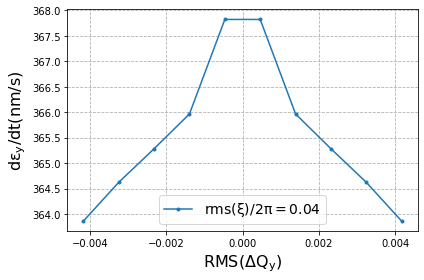

In [75]:
plt.plot(rms_DQy_list, np.array(emity_total)*1e9, '.-', c='C0', label=r'$\rm rms(\xi)/2\pi=0.04$')
plt.grid(linestyle='--')
plt.xlabel(r'$\rm RMS(\Delta Q_y)$', fontsize=16)
plt.ylabel(r'$\rm d\epsilon _y/dt (nm/s)$', fontsize = 16)
plt.tight_layout()
plt.legend(fontsize=14)
plt.savefig('dey_theory_PSD3_2e-20_ayy1e5.png')


### Compute the PSD of the signal

In [54]:
PSD_vb = psd_vb_list[0] #1.58e-20  # rad^2/Hz
alpha = PSD_vb*(scale_factor)**2 # scaled to the simulations
mu = 0.18*frev
c = 0.06*frev # the rms width of the colored noise
noise_psd = lambda f : gaussian_distribution(f, mu, c, alpha)

In [55]:
noise_psd(7821) # test psd tat the betatron sideband

2.5833825493844083e-09

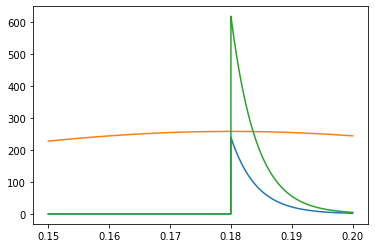

In [56]:
x = np.linspace(0.15,0.2, 10000)
plt.plot(x, rho_b(x))
plt.plot(x, 1e11*noise_psd(x*frev))
plt.plot(x, rho_b(x)*1e9*noise_psd(x*frev))

### Call the function computing the emittance

In [65]:
# Sanity check, it should equal 1
integrate.quad(lambda vb: rho_b(vb), 0.1, 2) 

(-3.170158442932027e+189, 3.6938885642614266e+179)

In [63]:
ey_geom_rate_phi = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaPhi, noise_psd, rho_b)
ey_norm_rate_phi = ey_geom_rate_phi*beta_0*gamma_0

In [64]:
print('dey/dt = {} nm/s'.format(ey_norm_rate_phi*1e9))

dey/dt = -4.5378538743397567e+46 nm/s


In [59]:
print('dey/dt = {} nm/s'.format(ey_norm_rate_phi*1e9))

dey/dt = 181.93022888850038 nm/s


print('dey/dt = {} nm/s'.format(ey_norm_rate_phi*1e9))